## Exploring Clip and it's alternative model, and fine Tuning 

#### 1. Data Loading via HuggingFace

In [1]:
''' dataset from huggingface - https://huggingface.co/datasets/jonathan-roberts1/Million-AID'''
from datasets import load_dataset

ds = load_dataset("jonathan-roberts1/Million-AID")

In [2]:
print(ds) # printing the structure of dataset (label3 is the import label that we need)

DatasetDict({
    train: Dataset({
        features: ['image', 'label_1', 'label_2', 'label_3'],
        num_rows: 10000
    })
})


In [ ]:
entry = ds['train'][120] # printing random information of the data
entry

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label_1': 1,
 'label_2': 22,
 'label_3': 41}

In [4]:
# image = entry['image']
# image 

In [5]:
dataset = ds['train'] # assigning the whole dataset, as the original one contain only 'train' subset.

#### 2. Loading the Model

In [ ]:
# excluding the ignore, that pops up randoms via compiling the code

import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import AutoProcessor, AutoModel

torch.cuda.empty_cache()

# original model from google/siglip
model = AutoModel.from_pretrained(
    "google/siglip-base-patch16-224", 
    torch_dtype=torch.float16,
    device_map="auto"
)
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

print("Model loaded successfully")

2025-06-28 17:44:04.601946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751125444.616998  326116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751125444.621602  326116 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-28 17:44:04.637576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model loaded successfully


In [7]:
# printing the model structure
print(model)

SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(32000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768

In [8]:
# as the label was in interger form, converting the integer label to string type for better understandig, as defined in the huggingface dataset
# This is crucial for both training prompts and visualizing results

label3_mapping = {
    0: 'dam', 1: 'parking lot', 2: 'greenhouse', 3: 'pier', 4: 'bridge',
    5: 'mine', 6: 'rock land', 7: 'baseball field', 8: 'apron',
    9: 'tennis court', 10: 'sparse shrub land', 11: 'works', 12: 'oil field',
    13: 'meadow', 14: 'ground track field', 15: 'detached house',
    16: 'golf course', 17: 'forest', 18: 'desert', 19: 'lake', 20: 'beach',
    21: 'paddy field', 22: 'ice land', 23: 'bare land', 24: 'storage tank',
    25: 'basketball court', 26: 'island', 27: 'substation',
    28: 'mobile home park', 29: 'cemetery', 30: 'quarry',
    31: 'solar power plant', 32: 'helipad', 33: 'roundabout', 34: 'runway',
    35: 'wastewater plant', 36: 'river', 37: 'apartment', 38: 'dry field',
    39: 'intersection', 40: 'swimming pool', 41: 'commercial area',
    42: 'church', 43: 'road', 44: 'orchard', 45: 'terraced field',
    46: 'stadium', 47: 'train station', 48: 'railway', 49: 'viaduct',
    50: 'wind turbine'
}


#### 3. Zero shot classification using base model

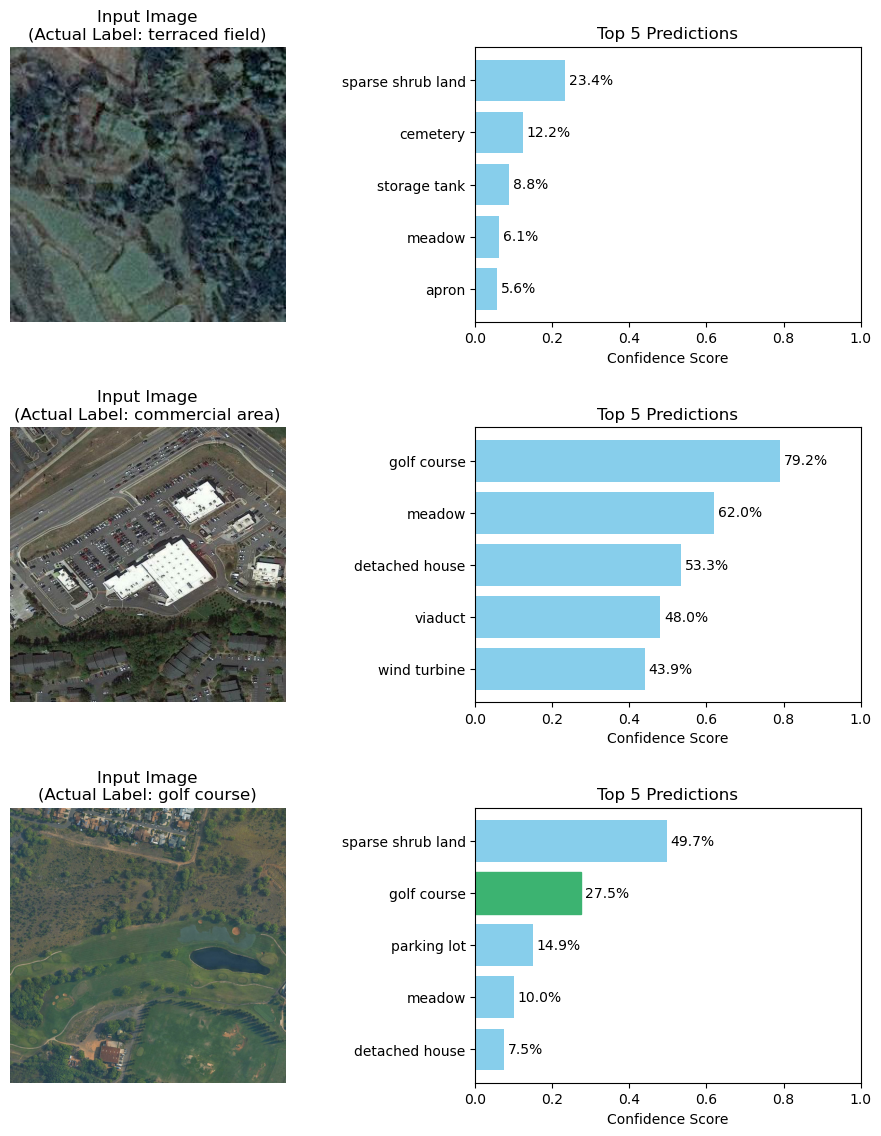

In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# make sure to set the device to cuda if available, otherwise use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_samples = 3
labels = list(label3_mapping.values())
prompt_template = "a satellite image of a {}" # simple template prompt 


# Pre-compute Text Features via text encoder 
# This step is done only once to avoid recomputing for each image
all_text_prompts = [prompt_template.format(label) for label in labels]

# generate the whole text embeddings for all labels
text_inputs = processor(text=all_text_prompts, padding=True, return_tensors="pt").to(device)

# telling the model not to compute gradients for text features
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# select images and calculates it's embeddings
indices = random.sample(range(len(dataset)), num_samples) # select random indices from the dataset

# Set up the figure for visualization
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
if num_samples == 1:
    axes = np.array([axes])

# iterate through the selected indices and process each image
for i, idx in enumerate(indices):
    example = dataset[idx]
    image = example['image']
    true_label = label3_mapping[example['label_3']]

    # Process the image and get features
    image_inputs = processor(images=image, return_tensors="pt").to(device, dtype=torch.float16)
    with torch.no_grad(): # Disable gradient computation 
        image_features = model.get_image_features(**image_inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    # Calculate Similarity and Probabilities for each image
    # and then mulitply by the logit scale it by some temperature factor, which SigLIP was already trained one to smooth the model outputs probabilities
    logits_per_image = (image_features @ text_features.t()) * model.logit_scale.exp() 
    probs = torch.sigmoid(logits_per_image).squeeze().cpu()

    #  Visualize Results, only show the image with the top 5 best similarities score
    top_probs, top_indices = torch.topk(probs, 5)
    
    # Detach from the graph and convert to NumPy ONCE for plotting
    top_scores = top_probs.detach().numpy()
    top_labels = [labels[j] for j in top_indices]

    # Display the input image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Input Image\n(Actual Label: {true_label})")
    axes[i, 0].axis('off')

    # Create a horizontal bar chart
    y_pos = np.arange(len(top_labels))
    bars = axes[i, 1].barh(y_pos, top_scores, color='skyblue')
    axes[i, 1].set_yticks(y_pos)
    axes[i, 1].set_yticklabels(top_labels)
    axes[i, 1].invert_yaxis()  # Highest score at the top
    axes[i, 1].set_xlabel("Confidence Score")
    axes[i, 1].set_title("Top 5 Predictions")
    axes[i, 1].set_xlim(0, 1)

    # Add percentage labels to the bars and highlight the correct one
    for bar_idx, bar in enumerate(bars):
        score = bar.get_width()
        # Highlight the correct label if it's in the top 5
        if top_labels[bar_idx] == true_label:
            bar.set_color('mediumseagreen')
        # Add the percentage text next to the bar
        axes[i, 1].text(
            score + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f'{score:.1%}',  # for percentage
            va='center'
        )

# Adjust layout and show the final plot
plt.tight_layout(pad=3.0)
plt.show()

In [10]:
print(image_features) # print image embeddings (it's for one image) [1, 768] tensor

tensor([[ 1.0933e-02, -2.9129e-02, -1.2978e-02,  1.8845e-02,  3.7231e-02,
          7.7744e-03,  5.6648e-03,  4.9477e-03, -2.0279e-02, -3.6804e-02,
          1.2390e-02,  1.2123e-02, -3.0090e-02,  1.0914e-04, -2.9259e-03,
          6.0005e-03, -4.3488e-03,  3.0914e-02,  5.6305e-02,  1.3504e-02,
         -2.2247e-02, -2.8534e-02, -2.2842e-02,  3.6133e-02, -1.8997e-02,
          1.5350e-02,  9.2697e-03,  2.9907e-02,  2.7122e-03, -8.4381e-03,
         -4.1809e-02, -5.0507e-02, -1.7807e-02,  3.6168e-04,  2.6428e-02,
          3.3112e-02, -1.1185e-02, -7.0953e-03,  1.4000e-02,  1.1963e-02,
          9.1858e-03, -8.1253e-03, -2.5787e-03,  4.9255e-02, -1.4908e-02,
          1.0147e-02,  3.0853e-02,  2.2018e-02,  9.2697e-03,  8.9905e-02,
         -2.0386e-02, -9.8419e-03,  9.2010e-03,  4.5128e-03,  6.7932e-02,
          6.4514e-02,  1.9409e-02,  1.7273e-02, -1.8982e-02, -1.7258e-02,
          8.2016e-03, -6.5575e-03, -1.5945e-02, -7.4234e-03,  3.1036e-02,
         -8.5297e-03,  8.5068e-03,  7.

In [33]:
image_features.shape # image embeddings shape (image, no. of dimmensions)

torch.Size([1, 768])

In [11]:
print(text_features) # text embeddings, it's for the whole text embeddings [50, 768] tensor

tensor([[-0.0392, -0.0077, -0.0401,  ...,  0.0128,  0.0266, -0.0033],
        [-0.0308, -0.0079, -0.0129,  ..., -0.0075,  0.0238,  0.0168],
        [-0.0516, -0.0268, -0.0203,  ...,  0.0126,  0.0019, -0.0031],
        ...,
        [-0.0434, -0.0111, -0.0417,  ...,  0.0013,  0.0457,  0.0166],
        [-0.0388, -0.0288, -0.0122,  ..., -0.0015,  0.0208,  0.0158],
        [-0.0455, -0.0052, -0.0031,  ...,  0.0149, -0.0234, -0.0269]],
       device='cuda:0', dtype=torch.float16)


In [34]:
text_features.shape # text embeddings shape (51 label, no. of embeddings)

torch.Size([51, 768])

In [12]:
print(logits_per_image) # represents scaled version of the cosine similarity (basically the two matrices multiplied)

tensor([[-6.2148, -1.7402, -5.1211, -7.1602, -6.2773, -5.8086, -6.2266, -5.7539,
         -2.7812, -5.8477, -0.0106, -4.4297, -6.6133, -2.1992, -5.2227, -2.5195,
         -0.9673, -6.3633, -5.4531, -7.2266, -6.8438, -4.2539, -4.4141, -5.7305,
         -4.1680, -6.0273, -6.0625, -4.3477, -4.0352, -4.9688, -7.1836, -5.5117,
         -3.0078, -4.5664, -2.6328, -3.7246, -6.5938, -2.5898, -7.8594, -6.8281,
         -5.6562, -3.8613, -4.5156, -5.2148, -5.8906, -5.7734, -5.1172, -4.8555,
         -5.8594, -4.1992, -3.4023]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MulBackward0>)


In [35]:
logits_per_image.shape # resultant vector of similar score (1 image is matched per 51 label, so the shape is [1, 51])

torch.Size([1, 51])

#### 4. Processing the Dataset

 4.1 Introducing Data Augmentation

In [13]:
### introducing some transformations 

from torchvision import transforms

# Define a more advanced set of transforms for the training data
train_transforms = transforms.Compose([
    # Geometric Augmentations
    transforms.Resize((256, 256)),  # Resize to a slightly larger size
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Crop a random part of the image
    transforms.RandomHorizontalFlip(p=0.5), # 50% chance of horizontal flip
    transforms.RandomRotation(15), # Rotate by up to 15 degrees

    # Color Augmentations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1), # 10% chance of converting to grayscale

    # Other Augmentations
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),

    # Must be last after all other transforms
    transforms.ToTensor(),
    
    # Normalization should be after ToTensor
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711)),
    
    # Occlusion Augmentation (apply after normalization)
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False)
])


# The validation transforms remain the same: simple and consistent
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))
])

4.2 Creating own custom class 

In [14]:
from torch.utils.data import Dataset

# custom dataset class to handle the dataset and apply transformations
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        original_item = self.dataset[idx]
        image = original_item['image']
        label = original_item['label_3']

        if self.transform:
            image = self.transform(image)

        return image, label

4.3 Dataloader and applying the augmentations

In [15]:
from torch.utils.data import random_split, DataLoader
# dataloader is efficiently used loads and manages data which then can later used for training or evaluating a model

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

#random seed to get random split of the dataset
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(dataset, [train_size, val_size], generator=generator) # random split the dataset into training and validation subsets

# Apply the respective transforms
# Training dataset with augmentations
train_dataset = CustomDataset(train_subset, transform=train_transforms)

# Validation dataset with only essential transforms
val_dataset = CustomDataset(val_subset, transform=val_transforms)

# Now you can create your DataLoaders (`batch size` is just used for how much bunch of data you want to load at once)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

4.4 Plotting the augemented image

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

#  Use the same mean and std that used for normalization 
mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
std = torch.tensor([0.26862954, 0.26130258, 0.27577711])

def denormalize(tensor, mean, std):
    """Reverses the normalization on a tensor of images."""
    # The dimensions of mean and std need to be reshaped to [C, 1, 1]
    # to be broadcastable with the image tensor of shape [C, H, W].
    tensor = tensor.clone() # Make a copy to avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m) # In-place multiplication and addition
    return tensor

def view_batch(loader, title, n_images=12):
    """Visualizes a batch of images from a DataLoader."""
    # Get a single batch from the loader
    images, labels = next(iter(loader))
    
    # We only want to display n_images
    images = images[:n_images]
    labels = labels[:n_images]

    # Denormalize the images
    denormalized_images = [denormalize(img, mean, std) for img in images]
    
    # Create a grid of images
    # make_grid arranges them into a grid, permute changes [C, H, W] to [H, W, C] for matplotlib
    grid = make_grid(denormalized_images, nrow=4).permute(1, 2, 0)
    
    # Clip values to the valid [0, 1] range for displaying
    grid = np.clip(grid, 0, 1)

    # Plot the grid
    plt.figure(figsize=(12, 8))
    plt.imshow(grid)
    plt.title(title, fontsize=16)
    
    # Create labels string for the plot caption
    # Assuming labels are integers. Adjust if they are something else.
    labels_str = ", ".join([str(lbl.item()) for lbl in labels])
    plt.xlabel(f"First {n_images} labels in the batch: [{labels_str}]", fontsize=12)
    plt.axis('off')
    plt.show()

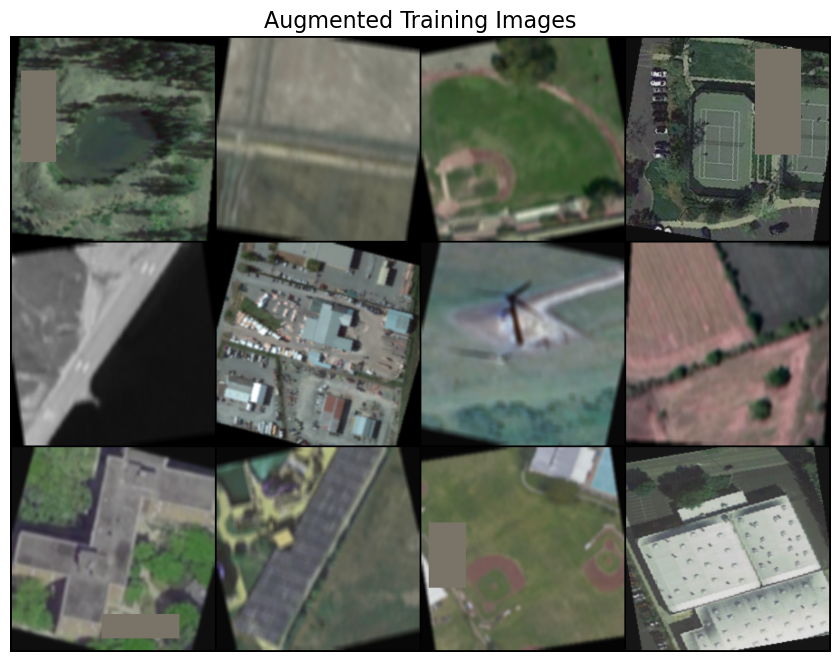

In [17]:
# View a batch from the Training DataLoader
view_batch(train_loader, title="Augmented Training Images")


#### 5. Fine tuning and Model Architecture
- Defines the fine-tuning model. 
- This class takes the pre-trained SigLIP model, freezes most of its weights, adds a new classification layer, and implements a gradual unfreezing strategy to only train the last few layers of the vision encoder

In [18]:
# install lion optimizer if not installed, the new optimizer efficient than AdamW optimiser 
# ! pip install lion-pytorch 

5.1 Model Architecture 

In [ ]:
# # --- PSEUDOCODE FOR THE SIGLIP FINE TUNING AS MENIONED IN THE PAPER ---

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np

# class SigLIPSimilarityModel(nn.Module):
#     def __init__(self, pretrained_model):
#         super().__init__()
#         self.model = pretrained_model
        
#         # --- Freeze the vision model (or unfreeze some layers as before) ---
        
#         # --- Introduce the learnable parameters from the paper ---
#         # We store 't' in log space for stability, as is common practice.
#         # Initial values are taken from the paper.
#         self.logit_scale = nn.Parameter(torch.tensor([np.log(10.0)]))
#         self.logit_bias = nn.Parameter(torch.tensor([-10.0]))
        
#         # print("Model created with learnable logit_scale (t) and logit_bias (b).")

#     def forward(self, image_pixel_values, text_features):
#         # 1. Get image features from the pretrained model
#         image_feat = self.model.get_image_features(pixel_values=image_pixel_values)
        
#         # 2. Normalize both image and text features (crucial for stable dot product)
#         image_feat = F.normalize(image_feat, p=2, dim=-1)
#         text_feat = F.normalize(text_features, p=2, dim=-1)
        
#         # 3. Calculate the cosine similarity (dot product of normalized vectors)
#         # This results in a matrix of size [batch_size, num_text_prompts]
#         logits = image_feat @ text_feat.T
        
#         # 4. Apply the learnable temperature (t) and bias (b)
#         # We use .exp() on the scale because we stored it in log space
#         logits = (self.logit_scale.exp() * logits) + self.logit_bias
        
#         return logits

In [37]:
from torch.optim.optimizer import Optimizer
from lion_pytorch import Lion
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

class SigLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes, layers_to_unfreeze=3):
        """
        The Vision Transformer in SigLIP-base has 12 layers (0 to 11).
        `layers_to_unfreeze=3` will unfreeze layers 9, 10, and 11.
        """
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(768, num_classes)

        # print("--- Freezing Strategy ---")
        # Freeze all parameters initially
        for param in self.model.parameters():
            param.requires_grad = False
        # print("All model parameters frozen.")
        
        # Selective Unfreezing
        # Unfreeze ONLY the last N layers of the vision encoder, whose weights we want to update via backpropagation.
        num_vision_layers = len(self.model.vision_model.encoder.layers)
        
        # We unfreeze from the end of the list backwards, means start from the last layer and move backwards.
        for i in range(num_vision_layers - layers_to_unfreeze, num_vision_layers):
            for param in self.model.vision_model.encoder.layers[i].parameters():
                param.requires_grad = True
            # print(f"Unfreezing vision encoder layer {i}")

        # We unfreeze the final LayerNorm for better stability (again just and experiment)
        for param in self.model.vision_model.post_layernorm.parameters():
            param.requires_grad = True
        # print("Unfreezing final post-layernorm in vision model.")
        
        # The new classifier head is always unfrozen by default, as its weights are new und updated via gradient descent method or Update rule.
        # print("Classifier head is unfrozen.")

    def forward(self, x):
        # Get image features from the (partially frozen) vision model
        features = self.model.get_image_features(x)
        # Pass these features to our new classifier to get logits (vector or even we latent space representation)
        logits = self.classifier(features.to(torch.float32))
        return logits, features

#  HYPERPARAMETERS CONFIGURATION

# 1. Setup the model with the new freezing strategy
# Let's start by unfreezing the last 3 layers of the vision encoder.
num_classes = len(label3_mapping) 
layers_to_unfreeze = 2 # Number of layers to unfreeze, can be adjusted based on the model architecture

# Initialize the fine-tuner with the model, number of classes, and layers to unfreeze
model_ft = SigLIPFineTuner(model, num_classes, layers_to_unfreeze).to(device)

# 2. Define the loss function

# CrossEntropyLoss is the correct choice for single-label, multi-class classification. It's more effective than BCEWithLogitsLoss for this task.
criterion = torch.nn.CrossEntropyLoss() # my job is just pick the ground truth label from the logits. 
# criterion = torch.nn.BCEWithLogitsLoss()


# 3. Setup the optimizer (Lion)
# Lion is more memory-efficient and converges faster especially for large transformer models.
# A lower LR is crucial to prevent catastrophic forgetting.
# Let's start with 1e-5.
LEARNING_RATE = 1e-5
optimizer = Lion(model_ft.parameters(), lr=LEARNING_RATE)

# 4. Setup the scheduler (no change here, but T_max could be reduced if you train for fewer epochs)
# Using CosineAnnealingLR because it smoothly and predictably reduces the learning rate over the training epochs.
# more stable minimum and avoid overshooting the optimal weights near the end of training
'''
optimizer (Optimizer) – Wrapped optimizer (Lion).
T_max (int) – Maximum number of iterations.
eta_min (float) – The minimum learning rate the scheduler can reach.
last_epoch (int) – The index of last epoch. Default: -1. # basically not needed if you know where to end your epochs.
'''
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-7) # Reduced T_max to 10 epochs as an example


In [20]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model_ft.parameters())

# Count the number of parameters that are being trained
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Percentage Trainable: {100 * trainable_params / total_params:.2f}%")
# ----------------------------------------

Total Parameters: 203,195,189
Trainable Parameters: 14,216,499
Percentage Trainable: 7.00%


5.2 Training and Validation loop

In [21]:
import torch
from tqdm.autonotebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 10 
best_val_accuracy = 0.0
model_save_path = "siglip_finetuned_best.pth"
# model_save_path = "siglip_finetuned_best_6layer.pth"


# Create lists to store metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting model training...")

for epoch in range(num_epochs):
    # --- Training Phase ---
    model_ft.train() # set model to training mode
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    # Use tqdm to create a progress bar for the training loop
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

    # doing mini-batch over the entire training dataset (training data is divided into - 32 batches)
    for images, labels in train_progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # always reset the gradients from previous batch to zero before computing new ones
        optimizer.zero_grad()

        # pass the batch of images through the model to get the output logits (vector representation)
        # The shape of class_logits will be [batch_size, num_classes]
        class_logits, _ = model_ft(images)
        
        # calculate the loss between the model's predictions (logits) and the true labels
        loss = criterion(class_logits, labels)

        #perform backpropagation to compute gradients
        loss.backward()
        # update the model weights based on the computed gradients
        optimizer.step()
        
        # accumulate the total loss for an epoch
        running_loss += loss.item() * images.size(0)
        
        # get the predicted class by finding the index of the maximum logit score
        _, predicted_labels = torch.max(class_logits, 1)
        # Count how many predictions in the batch were correct
        correct_predictions_train += (predicted_labels == labels).sum().item()
        # Count the total number of samples processed
        total_samples_train += labels.size(0)
        
        # update the bar
        train_progress_bar.set_postfix(loss=loss.item(), acc=f"{100*correct_predictions_train/total_samples_train:.2f}%")

    # after processing all batches in the epoch, update the learning rate according to the scheduler
    scheduler.step()

    # calculate the average loss and accuracy for the epoch
    epoch_loss_train = running_loss / len(train_loader.dataset)
    epoch_acc_train = correct_predictions_train / total_samples_train

    # --- Validation Phase ---
    # we evaluate the model on the unseen set of image to check its performance
    model_ft.eval()
    running_val_loss = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")

    # No gradients are needed during validation, so we use torch.no_grad() to save memory
    with torch.no_grad():
        for images, labels in val_progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            # perform a forward pass to get the logits
            class_logits, _ = model_ft(images)
            
            # calculate the loss for the validation set
            loss = criterion(class_logits, labels)
            
            running_val_loss += loss.item() * images.size(0)
            
            # The torch.max function looks at the 51 output scores and picks the index of the highest one. 
            # This is to turn the flexible output back into a single multi-class prediction.
            # Get the predicted class by finding the index of the maximum logit score
            _, predicted_labels = torch.max(class_logits, 1)
            correct_predictions_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)
            
            val_progress_bar.set_postfix(loss=loss.item(), acc=f"{100*correct_predictions_val/total_samples_val:.2f}%")

    # calculate the average loss and accuracy for the validation set
    epoch_loss_val = running_val_loss / len(val_loader.dataset)
    epoch_acc_val = correct_predictions_val / total_samples_val
    
    # --- SAVE METRICS FOR PLOTTING ---
    train_losses.append(epoch_loss_train)
    val_losses.append(epoch_loss_val)
    train_accuracies.append(epoch_acc_train)
    val_accuracies.append(epoch_acc_val)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss_train:.4f} | Train Acc: {epoch_acc_train:.4f} | Val Loss: {epoch_loss_val:.4f} | Val Acc: {epoch_acc_val:.4f}")

    # check if the current model has the best validation accuracy seen so far
    if epoch_acc_val > best_val_accuracy:
        best_val_accuracy = epoch_acc_val
        torch.save(model_ft.state_dict(), model_save_path)
        print(f"✅ New best model saved to {model_save_path} with validation accuracy: {best_val_accuracy:.4f}")

print("\nFinished Training!")
print(f"Best validation accuracy was: {best_val_accuracy:.4f}")

Starting model training...


Epoch 1/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 2.2609 | Train Acc: 0.4615 | Val Loss: 1.0552 | Val Acc: 0.7330
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.7330


Epoch 2/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.8742 | Train Acc: 0.7701 | Val Loss: 0.4767 | Val Acc: 0.8665
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.8665


Epoch 3/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.5524 | Train Acc: 0.8472 | Val Loss: 0.3509 | Val Acc: 0.8940
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.8940


Epoch 4/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.4419 | Train Acc: 0.8691 | Val Loss: 0.3035 | Val Acc: 0.9080
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.9080


Epoch 5/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.3394 | Train Acc: 0.9049 | Val Loss: 0.2591 | Val Acc: 0.9260
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.9260


Epoch 6/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.2840 | Train Acc: 0.9159 | Val Loss: 0.2312 | Val Acc: 0.9305
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.9305


Epoch 7/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.2676 | Train Acc: 0.9230 | Val Loss: 0.2160 | Val Acc: 0.9335
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.9335


Epoch 8/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.2342 | Train Acc: 0.9310 | Val Loss: 0.1992 | Val Acc: 0.9380
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.9380


Epoch 9/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.2212 | Train Acc: 0.9369 | Val Loss: 0.1967 | Val Acc: 0.9390
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.9390


Epoch 10/10 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.2230 | Train Acc: 0.9364 | Val Loss: 0.1962 | Val Acc: 0.9400
✅ New best model saved to siglip_finetuned_best.pth with validation accuracy: 0.9400

Finished Training!
Best validation accuracy was: 0.9400


5.3 Visualizes the training and validation loss and accuracy

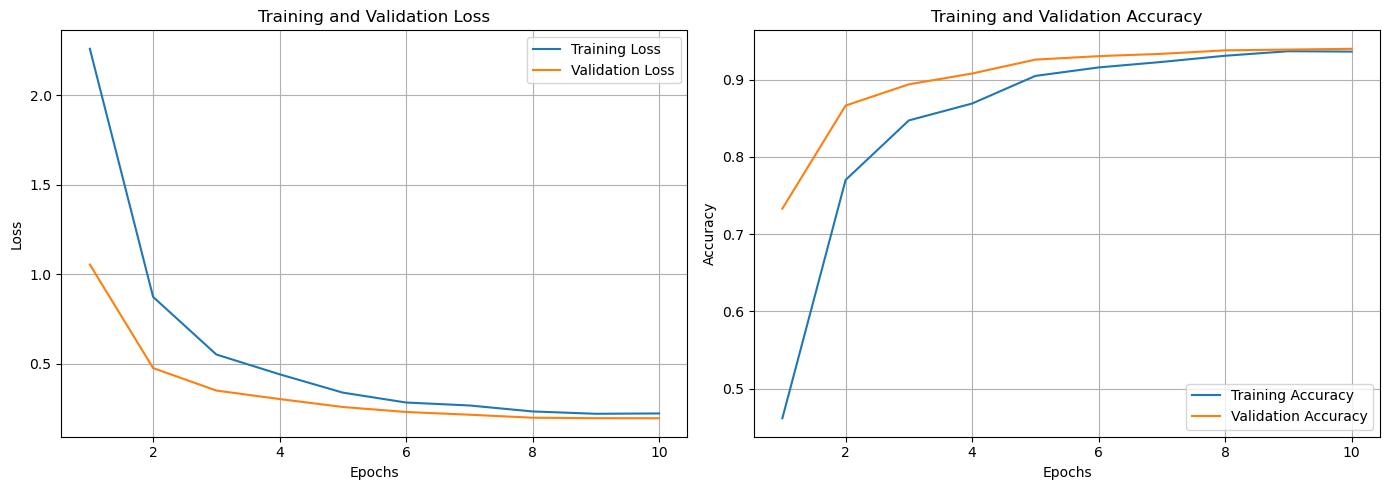

In [22]:
# --- Plotting Section ---
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

#### 6. Inference & Visualization with the fine-tuned model

Fine-tuned model loaded successfully and set to evaluation mode.


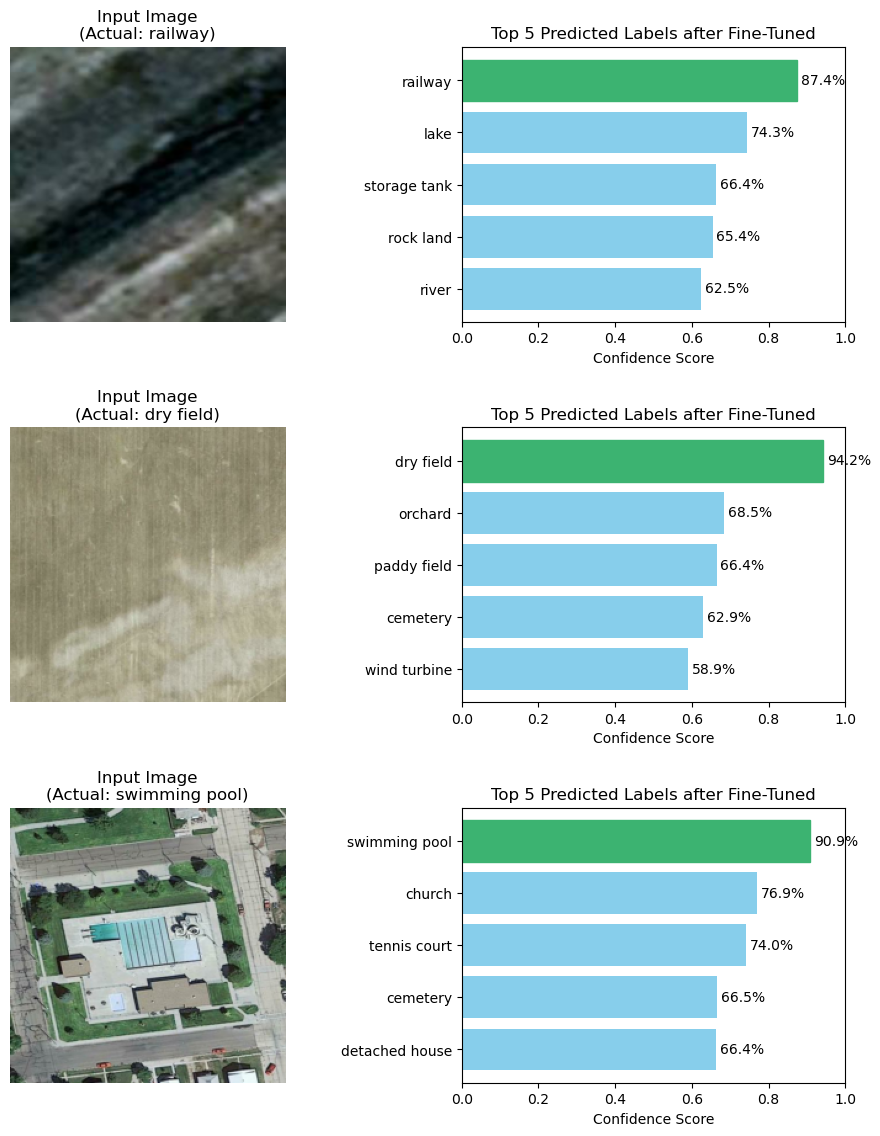

In [43]:
# a function to un-normalize and display a tensor image as all the images were in form of tesnor
def un_normalize_image(tensor):
    """Reverses the normalization on a tensor image to make it viewable."""
    # These are the means and stds used in your val_transforms
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
    
    # Clone the tensor to avoid modifying the original
    tensor = tensor.clone()
    
    # Reverse the normalization
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        
    # Transpose the image from (C, H, W) to (H, W, C) for matplotlib
    image = tensor.permute(1, 2, 0)
    # Clamp values to the valid range [0, 1]
    image = torch.clamp(image, 0, 1)
    return image.cpu().numpy()


# Load the fine-tuned model

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_save_path = "/home/6082/computer_vision/siglip_finetuned_best_6layer.pth"
model_save_path ="/home/6082/computer_vision/siglip_finetuned_best.pth"

# Now, instantiate your fine-tuned model architecture
# The number of layers to unfreeze doesn't matter here since we are loading trained weights
model_ft = SigLIPFineTuner(model, num_classes, layers_to_unfreeze=6) 

# Load the saved state dictionary means load the saved weights from best epoch
model_ft.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device and set it to evaluation mode
model_ft.to(device)
model_ft.eval()

print("Fine-tuned model loaded successfully and set to evaluation mode.")


# Perform prediction and visualization

num_samples = 3 

# Get random indices from the validation set
indices = np.random.choice(len(val_dataset), size=num_samples, replace=False).tolist()

# Create a figure for plotting
fig, axes = plt.subplots(len(indices), 2, figsize=(10, 4 * len(indices)))
if len(indices) == 1:
    axes = axes.reshape(1, -1) # Ensure axes is always a 2D array

# Process each selected image
for i, idx in enumerate(indices):
    # Get image tensor and its true label from the validation set
    image_tensor, actual_label_idx = val_dataset[idx]
    actual_category = label3_mapping[actual_label_idx]

    # The model expects a batch, so we add a batch dimension (B, C, H, W)
    input_tensor = image_tensor.unsqueeze(0).to(device)

    # to improve model calibration and output interpretation (the confidence scores)
    TEMPERATURE = 4.0 
    # Perform inference
    with torch.no_grad():
        class_logits, _ = model_ft(input_tensor)

        # Apply temperature scaling to the logits
        calibrated_logits = class_logits / TEMPERATURE

    # probs = torch.softmax(class_logits, dim=1).squeeze(0).cpu()
    # sigmoid to check the similary of each image-text pair 
    probs = torch.sigmoid(calibrated_logits).squeeze(0).cpu()

    # Get top 5 predictions for the bar chart
    top_probs, top_indices = torch.topk(probs, 5)
    top_categories = [label3_mapping[idx.item()] for idx in top_indices]
    top_scores = top_probs.tolist()

    # Display the input image (after un-normalizing it)
    display_image = un_normalize_image(image_tensor)
    axes[i, 0].imshow(display_image)
    axes[i, 0].set_title(f"Input Image\n(Actual: {actual_category})")
    axes[i, 0].axis('off')

    # Create horizontal bar chart for top 5 predictions
    y_pos = np.arange(len(top_categories))
    bars = axes[i, 1].barh(y_pos, top_scores, color='skyblue')
    axes[i, 1].set_yticks(y_pos)
    axes[i, 1].set_yticklabels(top_categories)
    axes[i, 1].invert_yaxis()  # Labels read top-to-bottom
    axes[i, 1].set_xlabel("Confidence Score")
    axes[i, 1].set_title("Top 5 Predicted Labels after Fine-Tuned")
    axes[i, 1].set_xlim(0, 1)  # Probabilities are between 0 and 1

    # Add percentage labels and highlight the correct label
    for bar_idx, bar in enumerate(bars):
        score = bar.get_width()
        # Highlight the bar in green if the prediction is correct
        if top_categories[bar_idx] == actual_category:
            bar.set_color('mediumseagreen')
        axes[i, 1].text(
            score + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f'{score:.1%}',
            va='center'
        )

# Show the final plot
plt.tight_layout(pad=3.0)
plt.show()

In [36]:
class_logits.shape # verifying the shape of the class logits, it should be [1, 51] tensor.

torch.Size([1, 51])

#### 7. Just using original zero shot task using SigLIP (very optional just for understanding)

Device set to use cuda:0


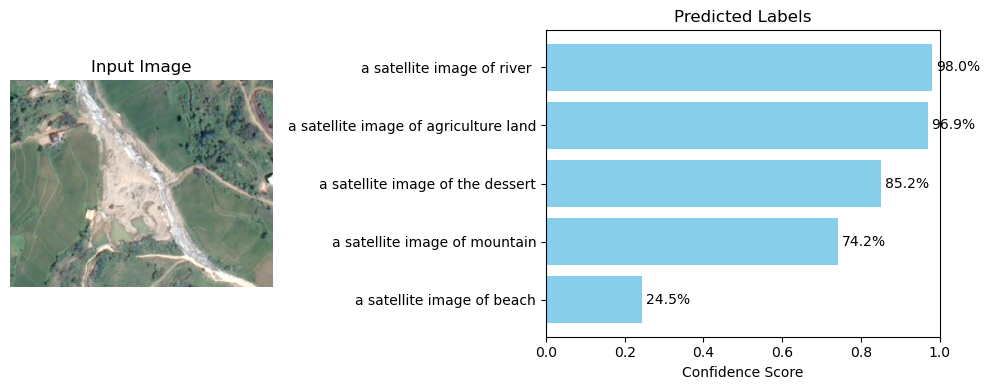

In [45]:
import torch
from PIL import Image
from transformers import pipeline
import matplotlib.pyplot as plt

# --- Load image ---
image_path = "/home/6082/computer_vision/trial.jpg"   
image = Image.open(image_path).convert("RGB")

# --- Candidate labels ---
candidate_labels = ["a satellite image of river ", "a satellite image of agriculture land", "a satellite image of the dessert", "a satellite image of beach", "a satellite image of mountain"]

# --- Zero-shot classifier pipeline ---
classifier = pipeline(
    task="zero-shot-image-classification",
    model="google/siglip-base-patch16-224",
    device=0,  # CUDA GPU
    torch_dtype=torch.bfloat16
)

# --- Run prediction ---
results = classifier(image, candidate_labels=candidate_labels)

# --- Extract labels and scores ---
labels = [r['label'] for r in results]
scores = [r['score'] for r in results]

# --- Plot image and histogram ---
fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1.5]})

# Image on the left
ax_img.imshow(image)
ax_img.axis('off')
ax_img.set_title("Input Image")

# Horizontal bar chart on the right
y_pos = range(len(labels))[::-1]  # Top label on top
ax_bar.barh(y_pos, scores, color='skyblue')
ax_bar.set_yticks(y_pos)
ax_bar.set_yticklabels(labels)
ax_bar.set_xlim(0, 1)
ax_bar.set_xlabel("Confidence Score")
ax_bar.set_title("Predicted Labels")

for i, score in enumerate(scores):
    ax_bar.text(score + 0.01, y_pos[i], f"{score:.1%}", va='center')

plt.tight_layout()
plt.show()
